# Data Sciency Stuff

### Import packages

In [64]:
import time
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, naive_bayes, svm

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

### Ignore plotting warnings

In [65]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Metrics function

* Generic function for calculating the number of class ratios
* Precision, Recall, F1
* Accuracy 

In [66]:
def model_metrics(Train_Y, Test_Y, predictions):
    print('===================================\n')
    print("Train target values count: ", Counter(Train_Y))
    print("Test target values count: ", Counter(Test_Y))
    print("Result values count: ", Counter(predictions))
    print('\n', metrics.classification_report(Test_Y, predictions))
    print("Accuracy Score: ",accuracy_score(predictions, Test_Y)*100)

## Import data

* Data wrangling
* Includes oversampling and undersampling for managing unbalanced classes

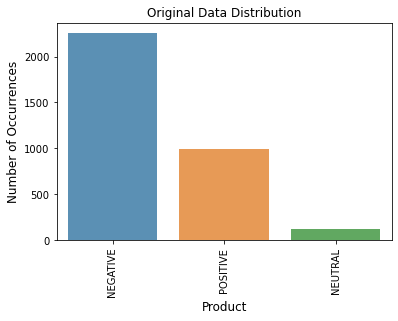

In [67]:

np.random.seed(42)

path = 'portal_articles_positivity_class.csv'

data = pd.read_csv(path)
data = data.dropna(subset = ['Title_positivity_sentence', 'Subtitle_positivity_sentence', 'Text_positivity_sentence'])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Original Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();


### Dataset balancing

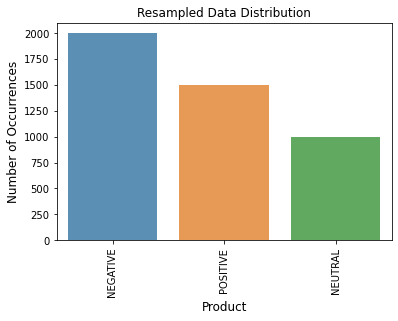

In [68]:

data_positive = data[data['Positivity'] == 'POSITIVE']
data_neutral = data[data['Positivity'] == 'NEUTRAL']
data_negative = data[data['Positivity'] == 'NEGATIVE']
#N!: 2256 P: 993 N: 121

# Downsample majority class
data_negative_downsampled = resample(data_negative, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class
                                 random_state=42) # reproducible results

# Upsample minority class
data_neutral_upsampled = resample(data_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples=993,    # to match majority class           
                                 random_state=42) # reproducible results
 
# Upsample minority class
data_positive_upsampled = resample(data_positive, 
                                 replace=True,     # sample with replacement
                                 n_samples=1500,    # to match majority class
                                 random_state=42) # reproducible results 
# Combine minority class with downsampled majority class
data = pd.concat([data_negative_downsampled,data_neutral_upsampled, data_positive_upsampled])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.title('Resampled Data Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();


## Training and testing split

In [69]:
start_time = time.time()

# Train and test set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['Article_text'], data['Positivity'], test_size=0.3, stratify=data['Positivity'])

kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)

#Encoder = LabelEncoder()
#Y_train = Encoder.fit_transform(Y_train)
#Y_test = Encoder.fit_transform(Y_test)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['Article_text'])
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

# SMOTE setup (If needed)
sm = SMOTE(random_state = 42)
X_train_tfidf_sm, Y_train_sm = sm.fit_resample(X_train_Tfidf, Y_train)

print("\n\nComputed in %s seconds." % (time.time() - start_time))




Computed in 3.1590397357940674 seconds.


## Naive Bayes

### Resampled

In [74]:
start_time = time.time()

NB = naive_bayes.MultinomialNB()
NB.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
NB_prediction_bal = NB.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

# Cross validation
NB_results_k_fold = model_selection.cross_val_score(NB, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)
print("Accuracy(K-Fold): %.3f (%.3f)" % (NB_results_k_fold.mean()*100, NB_results_k_fold.std()))

print('\nNaive Bayes (Default):')
model_metrics(Y_train, Y_test, NB_prediction_bal)

print("\n\nComputed in %s seconds." % (time.time() - start_time))


Accuracy(K-Fold): 74.881 (0.017)

Naive Bayes (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 693, 'POSITIVE': 442, 'NEUTRAL': 213})

               precision    recall  f1-score   support

    NEGATIVE       0.72      0.83      0.77       600
     NEUTRAL       0.88      0.63      0.73       298
    POSITIVE       0.73      0.72      0.72       450

    accuracy                           0.75      1348
   macro avg       0.78      0.72      0.74      1348
weighted avg       0.76      0.75      0.75      1348

Accuracy Score:  74.77744807121661


Computed in 0.31528329849243164 seconds.


## Support Vector Machine 

### Resampled

In [70]:
start_time = time.time()

# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='linear', class_weight='balanced', probability=True, degree=3, gamma='auto')

#Cross validation
SVM_results_k_fold = model_selection.cross_val_score(SVM, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)
print("Accuracy(K-Fold): %.3f (%.3f)" % (SVM_results_k_fold.mean(), SVM_results_k_fold.std()))

SVM.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
SVM_prediction = SVM.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

print('\nSVM (Default):')
model_metrics(Y_train, Y_test, SVM_prediction)

print("\n\nComputed in %s seconds." % (time.time() - start_time))

[0.86327504 0.85055644 0.85691574 0.84419714 0.85691574]

SVM (Default):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 580, 'POSITIVE': 466, 'NEUTRAL': 302})

               precision    recall  f1-score   support

    NEGATIVE       0.86      0.83      0.85       600
     NEUTRAL       0.93      0.94      0.93       298
    POSITIVE       0.80      0.83      0.82       450

    accuracy                           0.86      1348
   macro avg       0.86      0.87      0.87      1348
weighted avg       0.86      0.86      0.86      1348

Accuracy Score:  85.53412462908013


Computed in 157.62331342697144 seconds.


## Random Forest

### Resampled

In [61]:
start_time = time.time()
RF = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=42)

# Cross validation
RF_results_k_fold = model_selection.cross_val_score(RF, X_train_Tfidf, Y_train, cv=kfold, scoring='accuracy', n_jobs=4)
print("Accuracy(K-Fold): %.3f (%.3f)" % (RF_results_k_fold.mean()*100, RF_results_k_fold.std()))

RF.fit(X_train_Tfidf, Y_train)# predict the labels on validation dataset
RF_prediction = RF.predict(X_test_Tfidf)# Use accuracy_score function to get the accuracy

print('\nRandom Forest (Resampled):')
model_metrics(Y_train, Y_test, RF_prediction)

print("\n\nComputed in %s seconds." % (time.time() - start_time))



Accuracy(K-Fold): 89.126 (0.011)

Random Forest (Resampled):

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 1050, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 450, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 614, 'POSITIVE': 439, 'NEUTRAL': 295})

               precision    recall  f1-score   support

    NEGATIVE       0.90      0.92      0.91       600
     NEUTRAL       1.00      0.99      0.99       298
    POSITIVE       0.90      0.88      0.89       450

    accuracy                           0.92      1348
   macro avg       0.93      0.93      0.93      1348
weighted avg       0.92      0.92      0.92      1348

Accuracy Score:  92.13649851632047


Computed in 9.674824953079224 seconds.
